# Data Simulation for Predictive Maintenance

This notebook creates realistic sensor data for:
- **Vibration sensors** (acceleration, velocity)
- **Temperature sensors** (bearing, motor, ambient)
- **Process data** (RPM, load, current)
- **Degradation indicators** (degrading signals)

The simulated data can be used for training ML models.

## Contents
1. Setup and Libraries
2. Normal Operating Data
3. Fault Scenarios (Unbalance, Bearing Damage, Overheating)
4. Degradation Curves for RUL Training
5. Data Export

In [1]:
# Install required packages
# !pip install numpy pandas matplotlib scikit-learn scipy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from datetime import datetime, timedelta
import os

# Reproducible results
np.random.seed(42)

# Output directory
DATA_DIR = '../data/simulated'
os.makedirs(DATA_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


## 1. Base Simulators

Basic classes for generating different sensor types.

In [3]:
class VibrationSimulator:
    """
    Simulates vibration data from a rotating system.
    
    Models:
    - Fundamental frequency (RPM)
    - Harmonics (2x, 3x, ...)
    - Noise
    - Fault frequencies (BPFO, BPFI, BSF, FTF for bearings)
    """
    
    def __init__(self, sample_rate=10000, rpm=1500):
        self.sample_rate = sample_rate
        self.rpm = rpm
        self.fundamental_freq = rpm / 60  # Hz
        
        # Typical bearing frequencies (normalized to shaft frequency)
        # For a typical ball bearing with 8 balls
        self.bpfo = 3.05  # Ball Pass Frequency Outer
        self.bpfi = 4.95  # Ball Pass Frequency Inner
        self.bsf = 1.99   # Ball Spin Frequency
        self.ftf = 0.38   # Fundamental Train Frequency
    
    def generate_normal(self, duration=1.0, amplitude=1.0):
        """
        Generates normal vibration data (healthy condition).
        """
        t = np.arange(0, duration, 1/self.sample_rate)
        
        # Fundamental frequency + harmonics
        vibration = amplitude * np.sin(2 * np.pi * self.fundamental_freq * t)
        vibration += 0.3 * amplitude * np.sin(2 * np.pi * 2 * self.fundamental_freq * t)  # 2x
        vibration += 0.1 * amplitude * np.sin(2 * np.pi * 3 * self.fundamental_freq * t)  # 3x
        
        # Light noise
        noise = np.random.normal(0, 0.05 * amplitude, len(t))
        
        return t, vibration + noise
    
    def generate_unbalance(self, duration=1.0, amplitude=1.0, severity=0.5):
        """
        Simulates unbalance - elevated 1x component.
        severity: 0.0 (mild) to 1.0 (severe)
        """
        t, vibration = self.generate_normal(duration, amplitude)
        
        # Elevated 1x component
        unbalance = severity * 2.0 * amplitude * np.sin(2 * np.pi * self.fundamental_freq * t)
        
        return t, vibration + unbalance
    
    def generate_bearing_fault(self, duration=1.0, amplitude=1.0, fault_type='outer', severity=0.5):
        """
        Simulates bearing damage.
        fault_type: 'outer' (outer race), 'inner' (inner race), 'ball' (rolling element)
        """
        t, vibration = self.generate_normal(duration, amplitude)
        
        # Fault frequency based on type
        if fault_type == 'outer':
            fault_freq = self.bpfo * self.fundamental_freq
        elif fault_type == 'inner':
            fault_freq = self.bpfi * self.fundamental_freq
        else:  # ball
            fault_freq = self.bsf * self.fundamental_freq
        
        # Impulse-like faults (periodic impacts)
        impulse_train = np.zeros_like(t)
        period_samples = int(self.sample_rate / fault_freq)
        impulse_width = int(period_samples * 0.02)  # 2% of period
        
        for i in range(0, len(t), period_samples):
            impulse_train[i:i+impulse_width] = 1.0
        
        # Exponentially decaying impulses
        decay = np.exp(-np.arange(impulse_width) / (impulse_width/3))
        for i in range(0, len(t), period_samples):
            end_idx = min(i + impulse_width, len(t))
            impulse_train[i:end_idx] *= decay[:end_idx-i]
        
        # High-frequency content (resonance excitation)
        resonance = np.sin(2 * np.pi * 3000 * t)  # Typical bearing resonance
        fault_signal = severity * amplitude * impulse_train * resonance
        
        return t, vibration + fault_signal
    
    def generate_misalignment(self, duration=1.0, amplitude=1.0, severity=0.5):
        """
        Simulates misalignment - elevated 2x component.
        """
        t, vibration = self.generate_normal(duration, amplitude)
        
        # Elevated 2x component (axial and radial)
        misalign = severity * 1.5 * amplitude * np.sin(2 * np.pi * 2 * self.fundamental_freq * t)
        
        return t, vibration + misalign

# Test
sim = VibrationSimulator(sample_rate=10000, rpm=1500)
t, normal = sim.generate_normal(duration=0.1)
print(f"Sample Rate: {sim.sample_rate} Hz")
print(f"Shaft Frequency: {sim.fundamental_freq} Hz")
print(f"Generated Samples: {len(t)}")

Sample Rate: 10000 Hz
Shaft Frequency: 25.0 Hz
Generated Samples: 1000


In [4]:
class TemperatureSimulator:
    """
    Simulates temperature data with realistic thermal properties.
    """
    
    def __init__(self, ambient_temp=25.0, operating_temp=65.0, thermal_constant=300):
        """
        ambient_temp: Ambient temperature (°C)
        operating_temp: Normal operating temperature (°C)
        thermal_constant: Thermal time constant (seconds)
        """
        self.ambient = ambient_temp
        self.operating = operating_temp
        self.tau = thermal_constant
    
    def generate_normal(self, duration_hours=24, sample_interval=60):
        """
        Generates normal temperature data with start/stop cycles.
        """
        n_samples = int(duration_hours * 3600 / sample_interval)
        t = np.arange(n_samples) * sample_interval / 3600  # Hours
        
        # Simulation: 8h operation, 16h standstill
        temp = np.zeros(n_samples)
        current_temp = self.ambient
        
        for i in range(n_samples):
            hour_of_day = (t[i] % 24)
            is_running = 6 <= hour_of_day < 22  # Operating from 6-22h
            
            target = self.operating if is_running else self.ambient
            # Exponential transition
            alpha = 1 - np.exp(-sample_interval / self.tau)
            current_temp = current_temp + alpha * (target - current_temp)
            
            # Light noise
            temp[i] = current_temp + np.random.normal(0, 0.5)
        
        return t, temp
    
    def generate_overheating(self, duration_hours=8, sample_interval=60, 
                             overheat_start=0.5, max_temp=120):
        """
        Simulates overheating (e.g., due to bearing damage or cooling failure).
        overheat_start: When overheating begins (0-1 relative to duration)
        """
        n_samples = int(duration_hours * 3600 / sample_interval)
        t = np.arange(n_samples) * sample_interval / 3600
        
        temp = np.zeros(n_samples)
        current_temp = self.operating
        overheat_idx = int(n_samples * overheat_start)
        
        for i in range(n_samples):
            if i < overheat_idx:
                target = self.operating
            else:
                # Progressive temperature rise
                progress = (i - overheat_idx) / (n_samples - overheat_idx)
                target = self.operating + progress * (max_temp - self.operating)
            
            alpha = 1 - np.exp(-sample_interval / (self.tau / 2))  # Faster rise
            current_temp = current_temp + alpha * (target - current_temp)
            temp[i] = current_temp + np.random.normal(0, 0.5)
        
        return t, temp

# Test
temp_sim = TemperatureSimulator()
t_temp, temp_normal = temp_sim.generate_normal(duration_hours=48)
print(f"Generated {len(temp_normal)} temperature measurements over {t_temp[-1]:.1f} hours")

Generated 2880 temperature measurements over 48.0 hours


In [5]:
class DegradationSimulator:
    """
    Simulates degradation curves for RUL (Remaining Useful Life) training.
    """
    
    def __init__(self, initial_health=100, failure_threshold=20):
        self.initial_health = initial_health
        self.failure_threshold = failure_threshold
    
    def generate_linear_degradation(self, n_cycles, noise_std=2.0):
        """
        Linear degradation (constant wear rate).
        """
        health = np.linspace(self.initial_health, self.failure_threshold, n_cycles)
        health += np.random.normal(0, noise_std, n_cycles)
        health = np.clip(health, 0, self.initial_health)
        
        rul = np.arange(n_cycles)[::-1]  # Remaining cycles
        
        return health, rul
    
    def generate_exponential_degradation(self, n_cycles, noise_std=2.0, rate=0.02):
        """
        Exponential degradation (accelerated aging).
        """
        t = np.arange(n_cycles)
        health = self.initial_health * np.exp(-rate * t)
        health = np.maximum(health, self.failure_threshold)
        health += np.random.normal(0, noise_std, n_cycles)
        health = np.clip(health, 0, self.initial_health)
        
        # Calculate RUL
        rul = np.zeros(n_cycles)
        for i in range(n_cycles):
            remaining = np.where(health[i:] <= self.failure_threshold)[0]
            rul[i] = remaining[0] if len(remaining) > 0 else n_cycles - i
        
        return health, rul
    
    def generate_piecewise_degradation(self, n_cycles, noise_std=2.0):
        """
        Piecewise degradation: Normal -> Accelerated (typical for bearings).
        """
        t = np.arange(n_cycles)
        
        # Phase 1: Slow degradation (0-70%)
        # Phase 2: Accelerated degradation (70-100%)
        breakpoint = int(n_cycles * 0.7)
        
        health = np.zeros(n_cycles)
        
        # Phase 1: Linear slow
        health[:breakpoint] = np.linspace(
            self.initial_health, 
            self.initial_health * 0.6, 
            breakpoint
        )
        
        # Phase 2: Exponential fast
        remaining = n_cycles - breakpoint
        start_val = health[breakpoint-1]
        health[breakpoint:] = start_val * np.exp(-0.05 * np.arange(remaining))
        
        health = np.maximum(health, self.failure_threshold)
        health += np.random.normal(0, noise_std, n_cycles)
        health = np.clip(health, 0, self.initial_health)
        
        # RUL
        rul = np.arange(n_cycles)[::-1]
        
        return health, rul

# Test
deg_sim = DegradationSimulator()
health, rul = deg_sim.generate_piecewise_degradation(500)
print(f"Health Index Range: {health.min():.1f} - {health.max():.1f}")
print(f"RUL Range: {rul.min():.0f} - {rul.max():.0f} cycles")

Health Index Range: 15.3 - 100.0
RUL Range: 0 - 499 cycles


## 2. Visualize Simulated Data

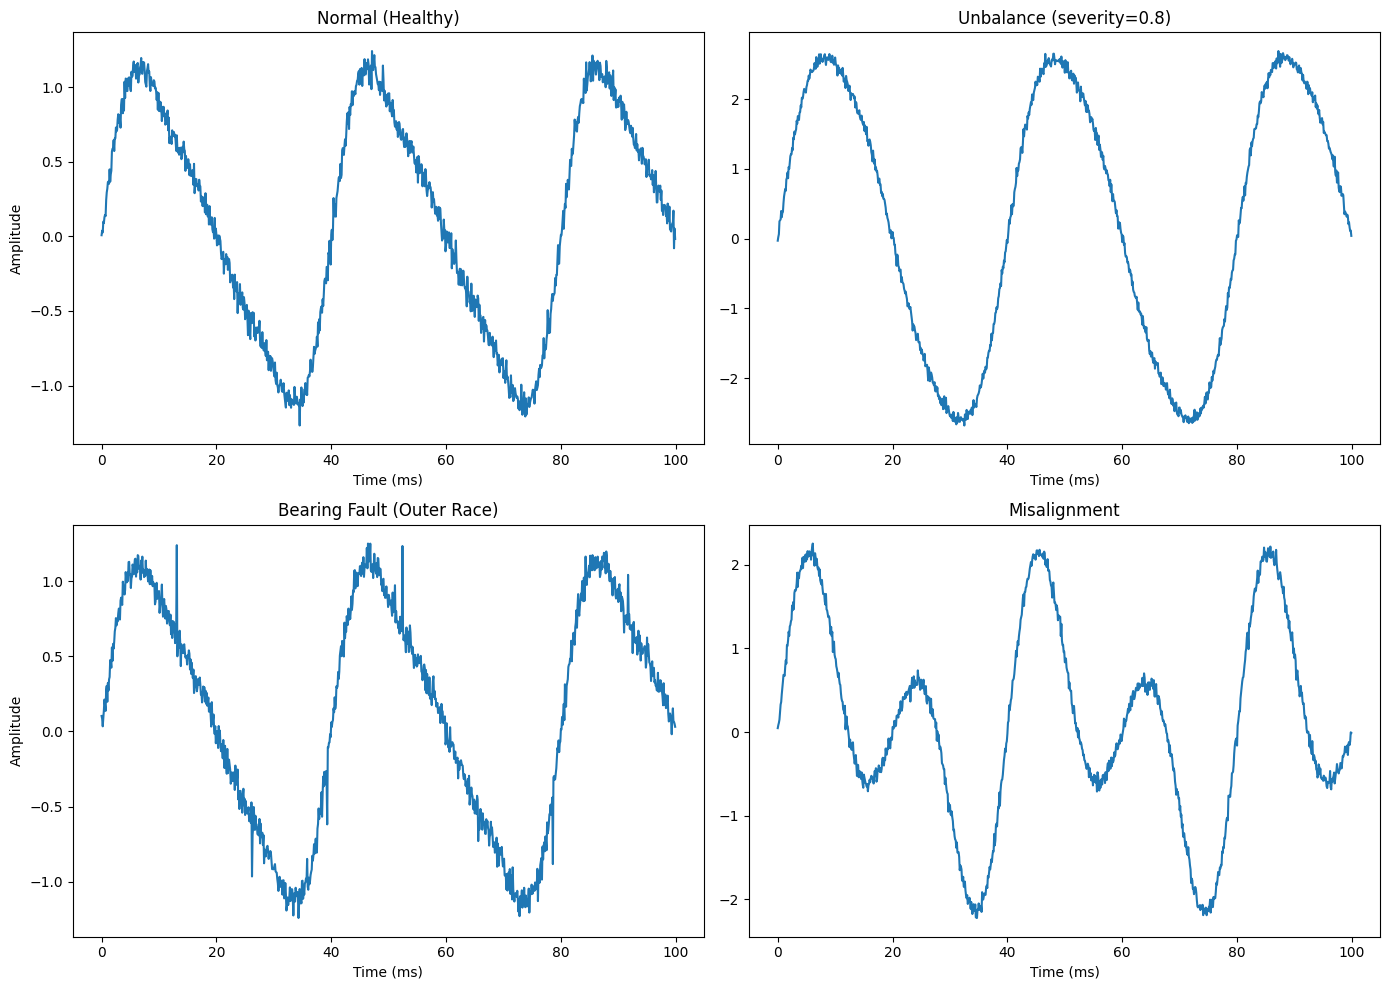

In [6]:
# Visualize vibration data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sim = VibrationSimulator(sample_rate=10000, rpm=1500)

# Normal
t, vib = sim.generate_normal(duration=0.1)
axes[0, 0].plot(t*1000, vib)
axes[0, 0].set_title('Normal (Healthy)')
axes[0, 0].set_xlabel('Time (ms)')
axes[0, 0].set_ylabel('Amplitude')

# Unbalance
t, vib = sim.generate_unbalance(duration=0.1, severity=0.8)
axes[0, 1].plot(t*1000, vib)
axes[0, 1].set_title('Unbalance (severity=0.8)')
axes[0, 1].set_xlabel('Time (ms)')

# Bearing fault
t, vib = sim.generate_bearing_fault(duration=0.1, fault_type='outer', severity=0.6)
axes[1, 0].plot(t*1000, vib)
axes[1, 0].set_title('Bearing Fault (Outer Race)')
axes[1, 0].set_xlabel('Time (ms)')
axes[1, 0].set_ylabel('Amplitude')

# Misalignment
t, vib = sim.generate_misalignment(duration=0.1, severity=0.7)
axes[1, 1].plot(t*1000, vib)
axes[1, 1].set_title('Misalignment')
axes[1, 1].set_xlabel('Time (ms)')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/vibration_examples.png', dpi=150)
plt.show()

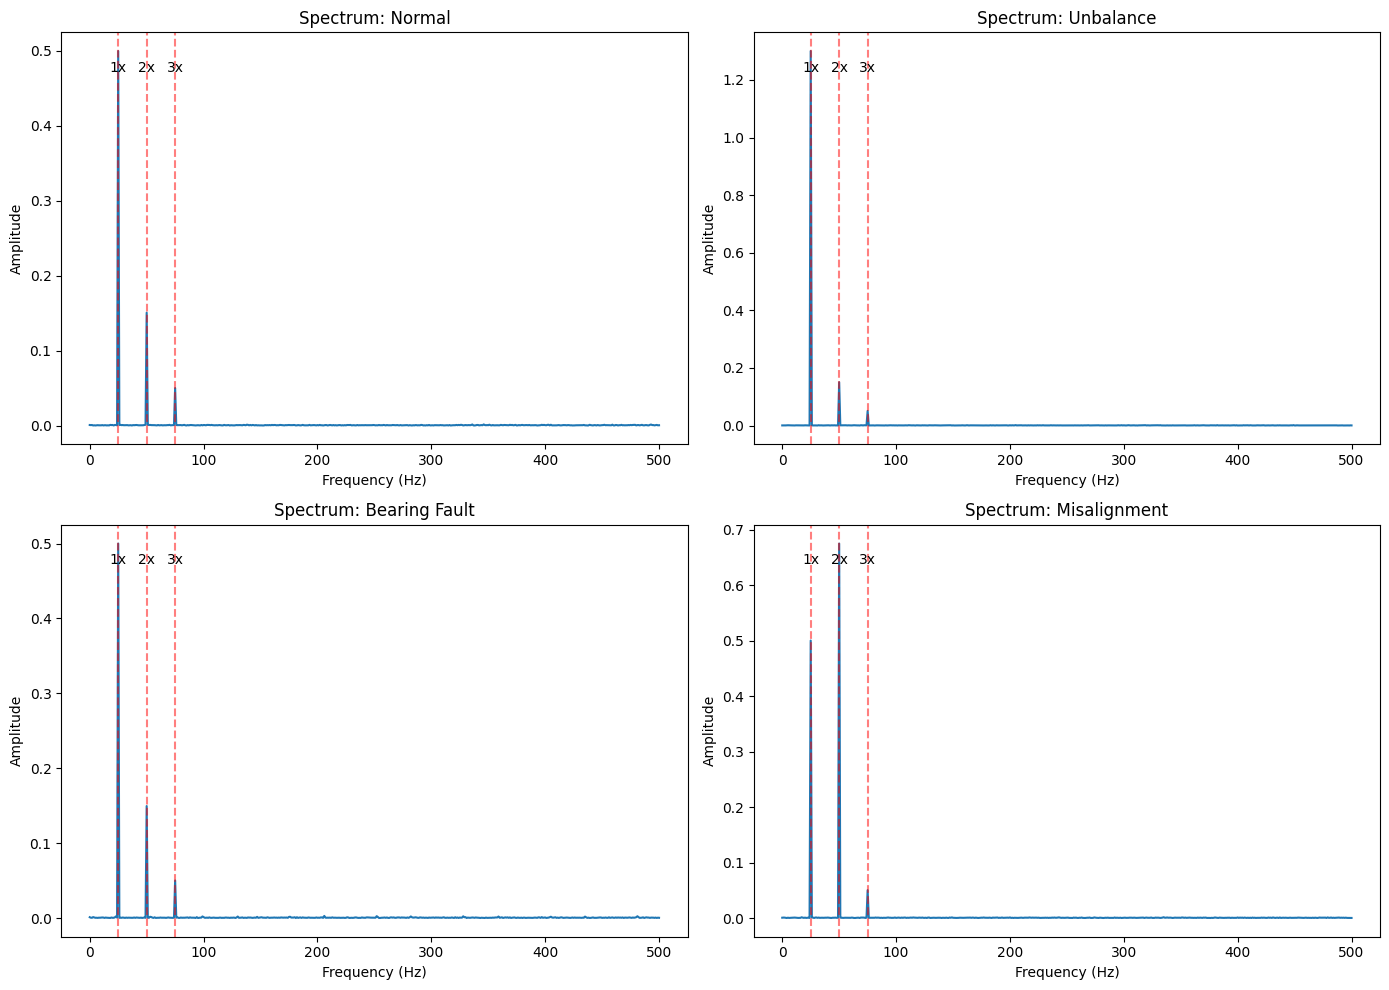

In [7]:
# Analyze frequency spectrum
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

def plot_spectrum(ax, t, vib, title):
    # Calculate FFT
    n = len(vib)
    freq = np.fft.rfftfreq(n, 1/sim.sample_rate)
    spectrum = np.abs(np.fft.rfft(vib)) / n
    
    # Plot up to 500 Hz
    mask = freq <= 500
    ax.plot(freq[mask], spectrum[mask])
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude')
    
    # Mark 1x, 2x, 3x
    for i, (f, label) in enumerate([(sim.fundamental_freq, '1x'), 
                                      (2*sim.fundamental_freq, '2x'),
                                      (3*sim.fundamental_freq, '3x')]):
        ax.axvline(f, color='r', linestyle='--', alpha=0.5)
        ax.text(f, ax.get_ylim()[1]*0.9, label, ha='center')

# Normal
t, vib = sim.generate_normal(duration=1.0)
plot_spectrum(axes[0, 0], t, vib, 'Spectrum: Normal')

# Unbalance (elevated 1x)
t, vib = sim.generate_unbalance(duration=1.0, severity=0.8)
plot_spectrum(axes[0, 1], t, vib, 'Spectrum: Unbalance')

# Bearing fault
t, vib = sim.generate_bearing_fault(duration=1.0, fault_type='outer', severity=0.6)
plot_spectrum(axes[1, 0], t, vib, 'Spectrum: Bearing Fault')

# Misalignment (elevated 2x)
t, vib = sim.generate_misalignment(duration=1.0, severity=0.7)
plot_spectrum(axes[1, 1], t, vib, 'Spectrum: Misalignment')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/spectrum_examples.png', dpi=150)
plt.show()

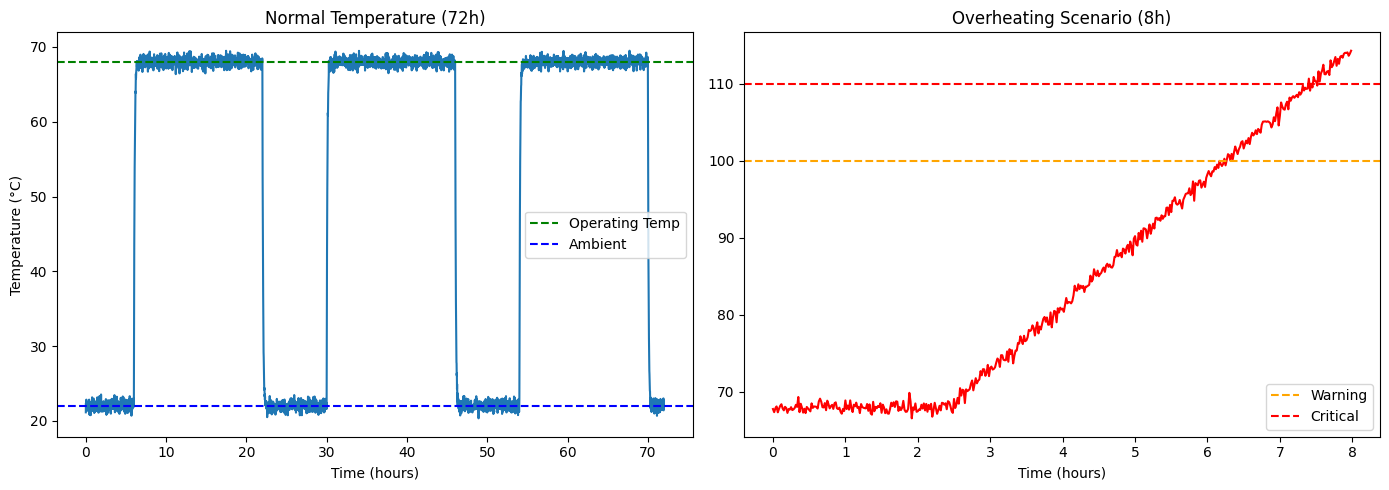

In [8]:
# Visualize temperature data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

temp_sim = TemperatureSimulator(ambient_temp=22, operating_temp=68)

# Normal
t, temp = temp_sim.generate_normal(duration_hours=72, sample_interval=60)
axes[0].plot(t, temp)
axes[0].set_title('Normal Temperature (72h)')
axes[0].set_xlabel('Time (hours)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].axhline(temp_sim.operating, color='g', linestyle='--', label='Operating Temp')
axes[0].axhline(temp_sim.ambient, color='b', linestyle='--', label='Ambient')
axes[0].legend()

# Overheating
t, temp = temp_sim.generate_overheating(duration_hours=8, overheat_start=0.3, max_temp=115)
axes[1].plot(t, temp, color='r')
axes[1].set_title('Overheating Scenario (8h)')
axes[1].set_xlabel('Time (hours)')
axes[1].axhline(100, color='orange', linestyle='--', label='Warning')
axes[1].axhline(110, color='r', linestyle='--', label='Critical')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/temperature_examples.png', dpi=150)
plt.show()

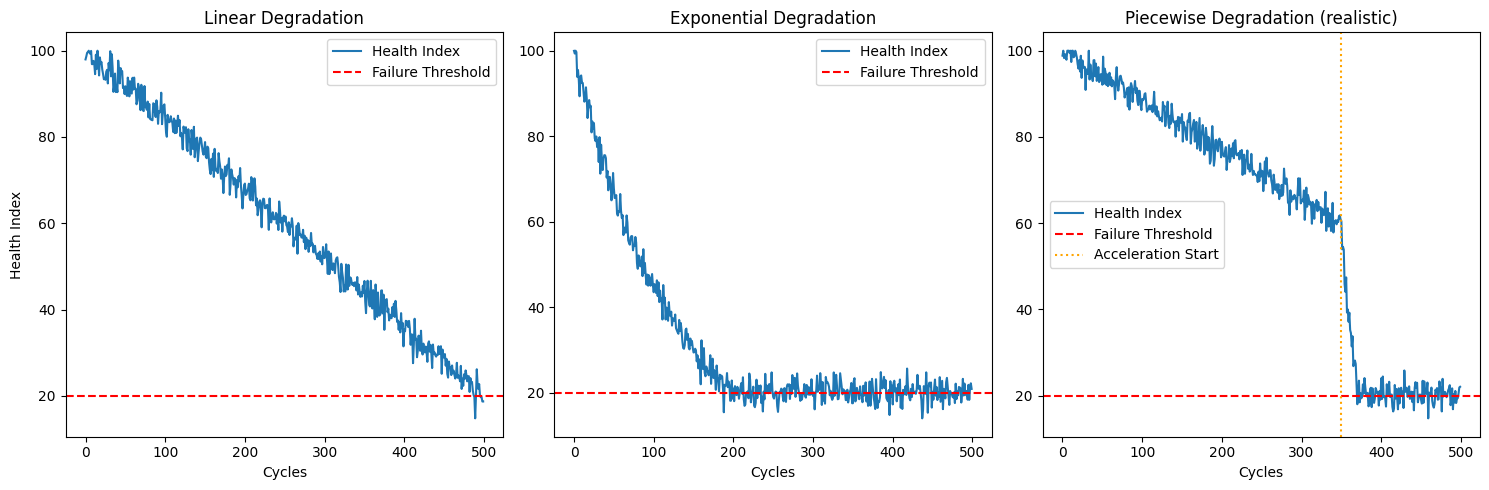

In [9]:
# Visualize degradation curves
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

deg_sim = DegradationSimulator(initial_health=100, failure_threshold=20)

# Linear
health, rul = deg_sim.generate_linear_degradation(500)
axes[0].plot(health, label='Health Index')
axes[0].axhline(20, color='r', linestyle='--', label='Failure Threshold')
axes[0].set_title('Linear Degradation')
axes[0].set_xlabel('Cycles')
axes[0].set_ylabel('Health Index')
axes[0].legend()

# Exponential
health, rul = deg_sim.generate_exponential_degradation(500, rate=0.008)
axes[1].plot(health, label='Health Index')
axes[1].axhline(20, color='r', linestyle='--', label='Failure Threshold')
axes[1].set_title('Exponential Degradation')
axes[1].set_xlabel('Cycles')
axes[1].legend()

# Piecewise (realistic)
health, rul = deg_sim.generate_piecewise_degradation(500)
axes[2].plot(health, label='Health Index')
axes[2].axhline(20, color='r', linestyle='--', label='Failure Threshold')
axes[2].axvline(350, color='orange', linestyle=':', label='Acceleration Start')
axes[2].set_title('Piecewise Degradation (realistic)')
axes[2].set_xlabel('Cycles')
axes[2].legend()

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/degradation_examples.png', dpi=150)
plt.show()

## 3. Generate Complete Datasets

We now create complete datasets for various ML tasks.

In [10]:
def extract_features(vibration_signal, sample_rate):
    """
    Extracts features from vibration signal for ML training.
    """
    features = {}
    
    # Time domain
    features['rms'] = np.sqrt(np.mean(vibration_signal**2))
    features['peak'] = np.max(np.abs(vibration_signal))
    features['crest_factor'] = features['peak'] / features['rms'] if features['rms'] > 0 else 0
    features['std'] = np.std(vibration_signal)
    features['kurtosis'] = np.mean((vibration_signal - np.mean(vibration_signal))**4) / (features['std']**4) if features['std'] > 0 else 0
    features['skewness'] = np.mean((vibration_signal - np.mean(vibration_signal))**3) / (features['std']**3) if features['std'] > 0 else 0
    
    # Frequency domain
    n = len(vibration_signal)
    freq = np.fft.rfftfreq(n, 1/sample_rate)
    spectrum = np.abs(np.fft.rfft(vibration_signal)) / n
    
    # Spectral features
    total_power = np.sum(spectrum**2)
    features['spectral_centroid'] = np.sum(freq * spectrum**2) / total_power if total_power > 0 else 0
    features['spectral_spread'] = np.sqrt(np.sum((freq - features['spectral_centroid'])**2 * spectrum**2) / total_power) if total_power > 0 else 0
    
    # Band energy (different frequency bands)
    bands = [(0, 100), (100, 200), (200, 500), (500, 1000), (1000, 3000)]
    for i, (low, high) in enumerate(bands):
        mask = (freq >= low) & (freq < high)
        features[f'band_{low}_{high}'] = np.sum(spectrum[mask]**2) / total_power if total_power > 0 else 0
    
    return features

# Test
t, vib = sim.generate_normal(duration=1.0)
features = extract_features(vib, sim.sample_rate)
print("Extracted Features:")
for name, value in features.items():
    print(f"  {name}: {value:.4f}")

Extracted Features:
  rms: 0.7437
  peak: 1.2973
  crest_factor: 1.7444
  std: 0.7437
  kurtosis: 1.6433
  skewness: 0.0006
  spectral_centroid: 38.9127
  spectral_spread: 195.0790
  band_0_100: 0.9955
  band_100_200: 0.0001
  band_200_500: 0.0003
  band_500_1000: 0.0004
  band_1000_3000: 0.0018


In [11]:
def generate_classification_dataset(n_samples_per_class=200):
    """
    Generates dataset for fault classification.
    
    Classes:
    0 = Normal
    1 = Unbalance
    2 = Bearing Fault
    3 = Misalignment
    """
    sim = VibrationSimulator(sample_rate=10000, rpm=1500)
    
    all_features = []
    all_labels = []
    
    print("Generating classification dataset...")
    
    for class_id, (name, generator) in enumerate([
        ('normal', lambda s: sim.generate_normal(duration=1.0)),
        ('unbalance', lambda s: sim.generate_unbalance(duration=1.0, severity=s)),
        ('bearing', lambda s: sim.generate_bearing_fault(duration=1.0, severity=s)),
        ('misalignment', lambda s: sim.generate_misalignment(duration=1.0, severity=s))
    ]):
        print(f"  Class {class_id} ({name}): ", end="")
        
        for i in range(n_samples_per_class):
            # Vary severity for fault classes
            severity = np.random.uniform(0.3, 1.0) if class_id > 0 else 0
            t, vib = generator(severity)
            
            features = extract_features(vib, sim.sample_rate)
            all_features.append(features)
            all_labels.append(class_id)
        
        print(f"{n_samples_per_class} samples")
    
    # Convert to DataFrame
    df = pd.DataFrame(all_features)
    df['label'] = all_labels
    df['label_name'] = df['label'].map({
        0: 'normal', 1: 'unbalance', 2: 'bearing', 3: 'misalignment'
    })
    
    return df

# Generate dataset
df_classification = generate_classification_dataset(n_samples_per_class=300)
print(f"\nDataset: {len(df_classification)} samples")
print(df_classification['label_name'].value_counts())

Generating classification dataset...
  Class 0 (normal): 

300 samples
  Class 1 (unbalance): 

300 samples
  Class 2 (bearing): 

300 samples
  Class 3 (misalignment): 

300 samples

Dataset: 1200 samples
label_name
normal          300
unbalance       300
bearing         300
misalignment    300
Name: count, dtype: int64


In [12]:
def generate_rul_dataset(n_units=50, cycles_range=(200, 500)):
    """
    Generates dataset for RUL (Remaining Useful Life) prediction.
    Similar to NASA Turbofan Dataset format.
    """
    sim = VibrationSimulator(sample_rate=10000, rpm=1500)
    deg_sim = DegradationSimulator(initial_health=100, failure_threshold=20)
    temp_sim = TemperatureSimulator()
    
    all_data = []
    
    print(f"Generating RUL dataset for {n_units} units...")
    
    for unit_id in range(n_units):
        # Random lifetime
        n_cycles = np.random.randint(cycles_range[0], cycles_range[1])
        
        # Degradation curve
        health, rul = deg_sim.generate_piecewise_degradation(n_cycles)
        
        for cycle in range(n_cycles):
            # Vibration signal degradation based on health
            degradation_factor = (100 - health[cycle]) / 100
            
            # Normal signal + increasing faults
            t, vib_normal = sim.generate_normal(duration=1.0)
            t, vib_fault = sim.generate_bearing_fault(duration=1.0, severity=degradation_factor)
            
            # Mix based on degradation
            vib = (1 - degradation_factor) * vib_normal + degradation_factor * vib_fault
            
            # Extract features
            features = extract_features(vib, sim.sample_rate)
            
            # Additional sensor data
            features['temperature'] = temp_sim.operating + degradation_factor * 30 + np.random.normal(0, 1)
            features['current'] = 10 + degradation_factor * 5 + np.random.normal(0, 0.5)
            
            # Metadata
            features['unit_id'] = unit_id
            features['cycle'] = cycle
            features['health_index'] = health[cycle]
            features['rul'] = rul[cycle]
            
            all_data.append(features)
        
        if (unit_id + 1) % 10 == 0:
            print(f"  {unit_id + 1}/{n_units} units")
    
    df = pd.DataFrame(all_data)
    return df

# Generate RUL dataset
df_rul = generate_rul_dataset(n_units=30, cycles_range=(150, 400))
print(f"\nRUL Dataset: {len(df_rul)} samples")
print(f"Units: {df_rul['unit_id'].nunique()}")
print(f"RUL Range: {df_rul['rul'].min():.0f} - {df_rul['rul'].max():.0f}")

Generating RUL dataset for 30 units...


  10/30 units


  20/30 units


  30/30 units

RUL Dataset: 8232 samples
Units: 30
RUL Range: 0 - 396


In [13]:
def generate_anomaly_dataset(n_normal=1000, n_anomaly=100):
    """
    Generates dataset for anomaly detection (unsupervised learning).
    """
    sim = VibrationSimulator(sample_rate=10000, rpm=1500)
    temp_sim = TemperatureSimulator()
    
    all_data = []
    
    print("Generating anomaly dataset...")
    
    # Normal data (for training)
    print(f"  Normal data: ", end="")
    for i in range(n_normal):
        t, vib = sim.generate_normal(duration=1.0)
        features = extract_features(vib, sim.sample_rate)
        features['temperature'] = temp_sim.operating + np.random.normal(0, 2)
        features['is_anomaly'] = 0
        all_data.append(features)
    print(f"{n_normal} samples")
    
    # Anomalies (for testing)
    print(f"  Anomalies: ", end="")
    anomaly_types = ['unbalance', 'bearing', 'misalignment', 'overheating']
    
    for i in range(n_anomaly):
        anomaly_type = np.random.choice(anomaly_types)
        severity = np.random.uniform(0.5, 1.0)
        
        if anomaly_type == 'unbalance':
            t, vib = sim.generate_unbalance(duration=1.0, severity=severity)
            temp = temp_sim.operating + np.random.normal(0, 2)
        elif anomaly_type == 'bearing':
            t, vib = sim.generate_bearing_fault(duration=1.0, severity=severity)
            temp = temp_sim.operating + severity * 15 + np.random.normal(0, 2)
        elif anomaly_type == 'misalignment':
            t, vib = sim.generate_misalignment(duration=1.0, severity=severity)
            temp = temp_sim.operating + severity * 10 + np.random.normal(0, 2)
        else:  # overheating
            t, vib = sim.generate_normal(duration=1.0)
            temp = temp_sim.operating + 40 + severity * 20 + np.random.normal(0, 2)
        
        features = extract_features(vib, sim.sample_rate)
        features['temperature'] = temp
        features['is_anomaly'] = 1
        features['anomaly_type'] = anomaly_type
        all_data.append(features)
    
    print(f"{n_anomaly} samples")
    
    df = pd.DataFrame(all_data)
    return df

# Generate anomaly dataset
df_anomaly = generate_anomaly_dataset(n_normal=1000, n_anomaly=150)
print(f"\nAnomaly Dataset: {len(df_anomaly)} samples")
print(df_anomaly['is_anomaly'].value_counts())

Generating anomaly dataset...
  Normal data: 

1000 samples
  Anomalies: 150 samples

Anomaly Dataset: 1150 samples
is_anomaly
0    1000
1     150
Name: count, dtype: int64


## 4. Save Datasets

In [14]:
# Save datasets
print("Saving datasets...")

df_classification.to_csv(f'{DATA_DIR}/classification_dataset.csv', index=False)
print(f"  ✓ classification_dataset.csv ({len(df_classification)} samples)")

df_rul.to_csv(f'{DATA_DIR}/rul_dataset.csv', index=False)
print(f"  ✓ rul_dataset.csv ({len(df_rul)} samples)")

df_anomaly.to_csv(f'{DATA_DIR}/anomaly_dataset.csv', index=False)
print(f"  ✓ anomaly_dataset.csv ({len(df_anomaly)} samples)")

# Summary
print(f"\n=== Datasets saved to {DATA_DIR} ===")
print(f"")
print(f"1. classification_dataset.csv")
print(f"   Task: Fault classification")
print(f"   Classes: normal, unbalance, bearing, misalignment")
print(f"   Features: {len(df_classification.columns) - 2}")
print(f"")
print(f"2. rul_dataset.csv")
print(f"   Task: Remaining Useful Life prediction")
print(f"   Units: {df_rul['unit_id'].nunique()}")
print(f"   Target variable: 'rul' (remaining cycles)")
print(f"")
print(f"3. anomaly_dataset.csv")
print(f"   Task: Anomaly detection")
print(f"   Normal: {len(df_anomaly[df_anomaly['is_anomaly']==0])}")
print(f"   Anomalies: {len(df_anomaly[df_anomaly['is_anomaly']==1])}")

Saving datasets...
  ✓ classification_dataset.csv (1200 samples)
  ✓ rul_dataset.csv (8232 samples)


  ✓ anomaly_dataset.csv (1150 samples)

=== Datasets saved to ../data/simulated ===

1. classification_dataset.csv
   Task: Fault classification
   Classes: normal, unbalance, bearing, misalignment
   Features: 13

2. rul_dataset.csv
   Task: Remaining Useful Life prediction
   Units: 30
   Target variable: 'rul' (remaining cycles)

3. anomaly_dataset.csv
   Task: Anomaly detection
   Normal: 1000
   Anomalies: 150


In [15]:
# Additional: Save raw time series for Deep Learning
def save_raw_timeseries(n_samples=500, duration=1.0):
    """
    Saves raw vibration time series for CNN/LSTM training.
    """
    sim = VibrationSimulator(sample_rate=10000, rpm=1500)
    
    n_points = int(duration * sim.sample_rate)
    
    X = []
    y = []
    
    generators = [
        (0, lambda: sim.generate_normal(duration=duration)),
        (1, lambda: sim.generate_unbalance(duration=duration, severity=np.random.uniform(0.3, 1.0))),
        (2, lambda: sim.generate_bearing_fault(duration=duration, severity=np.random.uniform(0.3, 1.0))),
        (3, lambda: sim.generate_misalignment(duration=duration, severity=np.random.uniform(0.3, 1.0)))
    ]
    
    samples_per_class = n_samples // len(generators)
    
    for label, gen in generators:
        for _ in range(samples_per_class):
            t, vib = gen()
            X.append(vib[:n_points])
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    # Save as numpy arrays
    np.save(f'{DATA_DIR}/timeseries_X.npy', X)
    np.save(f'{DATA_DIR}/timeseries_y.npy', y)
    
    print(f"Raw time series saved:")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    
    return X, y

X_raw, y_raw = save_raw_timeseries(n_samples=400, duration=0.5)

Raw time series saved:
  X shape: (400, 5000)
  y shape: (400,)


## 5. Summary

### Generated Datasets

| File | Task | Samples | Description |
|------|------|---------|-------------|
| `classification_dataset.csv` | Classification | 1200 | 4 fault classes |
| `rul_dataset.csv` | RUL Prediction | ~8000 | Degradation curves |
| `anomaly_dataset.csv` | Anomaly Detection | 1150 | Normal vs. Anomaly |
| `timeseries_X/y.npy` | Deep Learning | 400 | Raw vibrations |

### Next Steps

Use this data in the following notebooks:
- **02_anomaly_detection.ipynb** - Isolation Forest, Autoencoder
- **03_rul_prediction.ipynb** - LSTM, Gradient Boosting for RUL
- **04_classification.ipynb** - CNN, Random Forest for fault classification
- **05_model_export.ipynb** - Export for Node-RED (ONNX, TensorFlow.js)